# CS 3630 Project 3
## Outline
1. Markov Localization 
2. Particle Filtering
3. Comparing the two algorithms
4. Path following using particle filtering
5. Submission


## Logistics
1. Date range: 2/21/2022 21:00 Monday - 3/4/2022 23:59 Friday.
2. Submisson should be made to GradeScope. Please carefeully read the submission guideline at the end of the notebook.

## General Tips
1. Start early.
2. Make a copy of this Colab notebook and run.
3. You will need to use the `numpy` library to complete the coding parts.
4. Check out the table of contents by clicking the top icon on the left bar.
5. Read through every line of the notebook.
6. For coding questions, fill in the code cells before you run them.
7. Have fun!


Created by Lixing and Maya. Cool arts credit to Maya.

Want to learn more about particle filtering? Check out this here escape room: https://sites.google.com/view/particlefilter3630/home

# Set-Up: Make sure you run the following cells every time you restart Colab runtime

Some installations...

In [ ]:
%pip install -q -U gtbook
%pip install -U kaleido

     |████████████████████████████████| 20.7 MB 4.8 MB/s 
     |████████████████████████████████| 79.9 MB 132 kB/s 


Some imports...

In [ ]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import plotly.express as px
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import logistics
from gtbook.display import show
from IPython.display import clear_output


In [ ]:
np.random.seed(0)

Some variables...

In [ ]:
left = [(10+i*5,6) for i in range(9)]
up = [(50,6+i*5) for i in range(1,6)]
N = len(left) + len(up)
indices = range(1, N+1)
x = {k:gtsam.symbol('x',k) for k in indices}
values = gtsam.VectorValues()
for i, state in enumerate(left+up): values.insert(x[i+1], state)
values

Variable,value
x1,10 6
x2,15 6
x3,20 6
x4,25 6
x5,30 6
x6,35 6
x7,40 6
x8,45 6
x9,50 6
x10,50 11


In [ ]:
ground_truth = np.array([values.at(x[k]) for k in indices])
logistics.show_map(logistics.base_map, ground_truth)

In [ ]:
prior_mean = values.at(x[1])
prior_cov = np.diag([25,25])
prior = logistics.gaussian(logistics.map_coords, prior_mean, prior_cov)
logistics.show_map(prior/np.max(prior)+0.1*logistics.base_map)

Some functions...

In [ ]:
from skimage import io
import os
def create_slide_show():
  img_list = []
  k = 1
  while True:
    if not os.path.exists("{}.png".format(k)):
      #print("Images not found! Please run simulation to collect images first.")
      break
    img = io.imread("{}.png".format(k))
    img_list.append(img)
    os.remove("{}.png".format(k))
    k += 1
  img_list = np.array(img_list)
  fig = px.imshow(img_list, animation_frame=0)
  fig.update_layout(showlegend=False)
  fig.update_xaxes(visible=False)
  fig.update_yaxes(visible=False)
  fig.show()

In [ ]:
def show_trajectory(gts, ests):
  """ Utility function to show image on warehouse map, possibly with markers and robots """
  fig = px.imshow(0.1*logistics.base_map, color_continuous_scale='Oranges',
                  origin="lower", aspect='equal', range_color=[0, 1])
  
  fig.add_scatter(x=gts[:, 0], y=gts[:, 1],
                      mode="markers", marker=dict(color="green", opacity=1, size=10))
  fig.add_scatter(x=ests[:, 0], y=ests[:, 1],
                      mode="markers", marker=dict(color="red", opacity=1, size=10))
      
  fig.update_layout(coloraxis_showscale=False,
                    margin=dict(l=0, r=0, t=0, b=0))
  fig.update_xaxes(range=[-0.5, 99.5], autorange=False)
  fig.update_yaxes(range=[-0.5, 49.5], autorange=False,scaleratio = 1)
  fig.show()

# Part 1: Markov Localization

Meet Manuel, a robot that was born with the gift of Markov localization. Markov localization is an algorithm that uses a continuous state representation when performing localization task. Since the code of Markov Localization is already given to you in the textbook, we will focus on understanding the code and parameters that are used in Manuel's algorithm. For this section, you will tune Manuel's parameters and record the results in the online report on Gradescope.

![](https://drive.google.com/uc?export=view&id=1xbXUb59mSoPKmztWyIk4OUBccOeJMLK0)


*Art: Meet Manuel*

In [ ]:
def prediction_step(previous, control, motion_model_sigma):
    cov = np.eye(2) * motion_model_sigma**2
    predictive_density = np.zeros((50,100))
    for i in range(50):
        for j in range(100):
            if previous[i,j]>1e-5:
                previous_xy = logistics.map_coords[i,j]
                mean = previous_xy + control
                for k in range(50):
                    motion_model = logistics.gaussian(logistics.map_coords[k], mean, cov)
                    predictive_density[k] += motion_model * previous[i,j]
    predictive_density = predictive_density/np.sum(predictive_density)
    return predictive_density

Read the code above, and you will find that Manuel's motion is not deterministic: we assume that the distribution of Manuel's possible locations after the motion is gaussian with a mean value at each location that could possibly reached from Manuel's previous location and a covariance represented by the provided motion model sigma. In fact, Manuel could be at any position with non-zero probability, so you will need to help Manuel perform a motion update at any location with non-zero probability under the Markov continuous state model. ***This could be a problem if the number of states is huge.*** And in the current assignment, there are 5000 (50 * 100) cells in the grid map so there are 5000 states in total.

![](https://drive.google.com/uc?export=view&id=13PRNBJ2-Naac-MnyDwb-d4bpxDj3wJZC)


*Art: Where is Manuel?*

The following code is the main logic loop, or the "meat" of Markov Localization. In this example, Manuel wants to move between location values `k` and `k+1`. We get the current probability densities using the function above first with the motion model. We will correct the probability density by multiplying the likelihood given by our sensors; this will give us the posterior density. Below you will be able to run the code and observe the slide show.

In [ ]:
def run_markov(prior, indices, control_values, sigma, show_map=False):
  """
      Refer to the code in the text book for predictive density and posterior density calculation.
  """
  predictive_density = prior
  motion_model_sigma = sigma
  posterior_density = predictive_density * logistics.proximity_map_off
  posterior_density /= np.sum(posterior_density)
  posterior_density_sequence = [posterior_density]
  for k in indices[:-1]:
    control = control_values.at(x[k+1]) - control_values.at(x[k])  # ground truth control
    predictive_density = prediction_step(posterior_density, control, motion_model_sigma)
    posterior_density = predictive_density * logistics.proximity_map_off
    posterior_density /= np.sum(posterior_density)

    posterior_density_sequence.append(posterior_density)
    if show_map:
      logistics.show_map(posterior_density/np.max(posterior_density) + 0.1*logistics.base_map, file="{}.png".format(k))
      if k != indices[-2]:
        clear_output(wait=True)
  return posterior_density_sequence

### Coding
However, the above code doesn't really show Manuel moving - it just returns all the possible Manuels in the warehouse. There is only *one* Manuel we are concerned about. Therefore, we have to use these probabilities to estimate where the real Manuel is.
In the below cell, you will implement a function to figure out the estimated location from output posterior densities. Use the weighted average of the locations based on the posterior densities. (Hint: use `np.average()`). You probably will need to flatten the posterior densities.

In [ ]:
#Coding TODO 1
def get_markov_location_best_estimate(posterior_density):
    """
      posterior_density: 50 * 100 2d float array of posterior density
      
      Returns:
        best_estimate: (float, float), which is a coordinate (the wighted avereage of the positions)
    """
    positions = np.array([(j, i) for i in range(50) for j in range(100)])
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    best_estimate = np.average(positions, weights=posterior_density.flatten(), axis=0)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    return best_estimate

In the next cell, you will calculate the average distance between the estimated locations and the ground truth, **and the averaged distance would be used as the accuracy metric for the estimated locations in the assignment.** A higher accuracy means a lower average distance between the ground truth and the estimated locations.

You will use euclidean distance to calculate the distance between the estimated locations and the ground truth locations. (Tip: use `np.linalg.norm`) You will need to call the function you implemented above.

In [ ]:
#Coding TODO 2
def get_markov_location_error(posterior_density_sequence, ground_truth_values):
    """
        Loop over the ground truth values and calculate the accuracies using root mean square distance.
        Save your estimates in the best_estimates array and return with the average distance.

        posterior_density_sequence: List[50 * 100 2d float array], list of posterior density for each step
        ground_truth_values: List[(flost, float)], list of ground truth locations for each step

        Returns:
          average_distance: float, average distance to ground truth
          best_estimates: List[(float, float)], list of location estimations along the trajectory 
            for each step with length equals to the ground_truth_values
    """
    best_estimates = []
    average_distance = 0.0
    n = len(ground_truth_values)
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    for k in range(len(ground_truth_values)):
        p = posterior_density_sequence[k]
        best_estimate = get_markov_location_best_estimate(p)
        best_estimates.append(best_estimate)
        average_distance += np.linalg.norm(best_estimate - ground_truth_values[k])
    average_distance /= n
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    # Return the average average_distance
    return best_estimates, average_distance

In [ ]:
%%time
motion_model_sigma = 1.0 # Change sigma here
posterior_density_sequence = run_markov(prior, indices, values, motion_model_sigma, show_map=True)

gts = np.array([values.at(x[k]) for k in indices])
best_estimates, average_distance = get_markov_location_error(posterior_density_sequence, gts)
print("Average distance: ", average_distance)

Average distance:  1.189016505454354
CPU times: user 13.1 s, sys: 12.6 s, total: 25.6 s
Wall time: 25.5 s



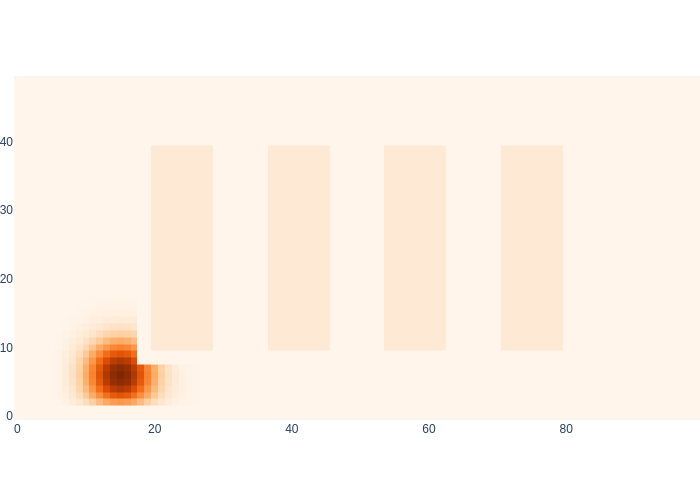
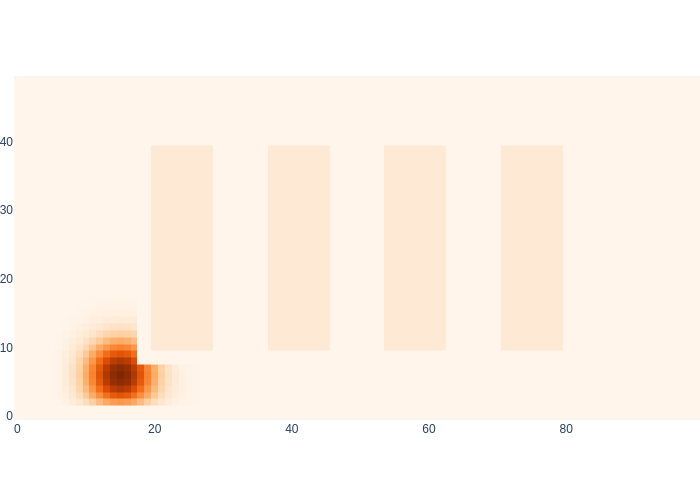
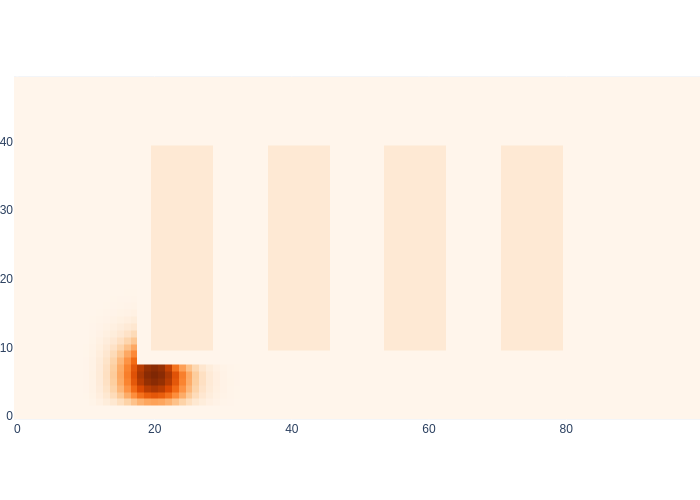
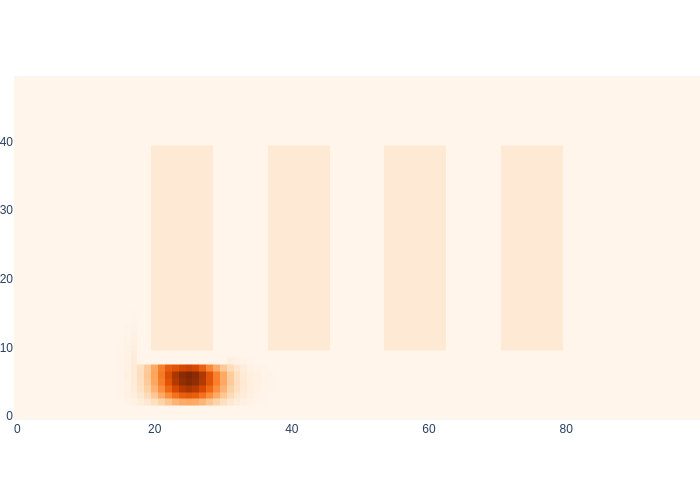
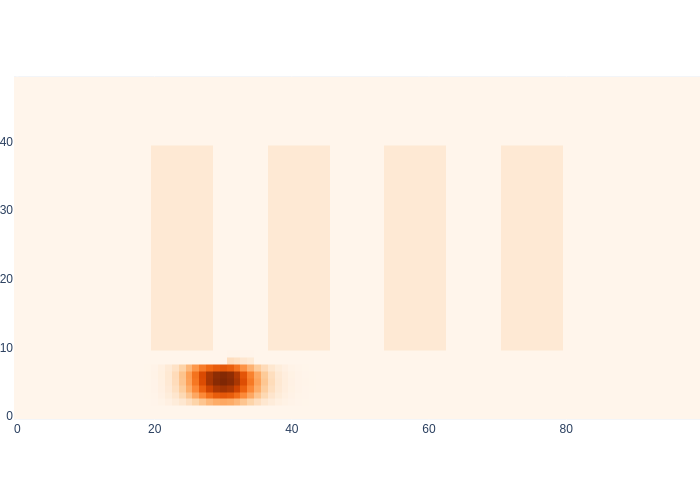
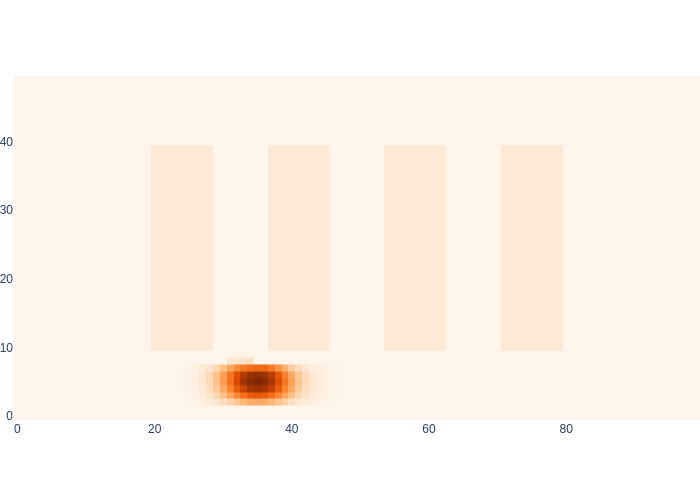
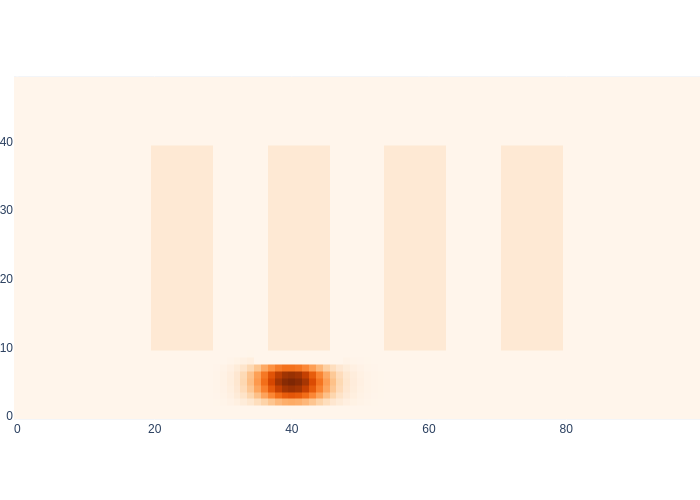
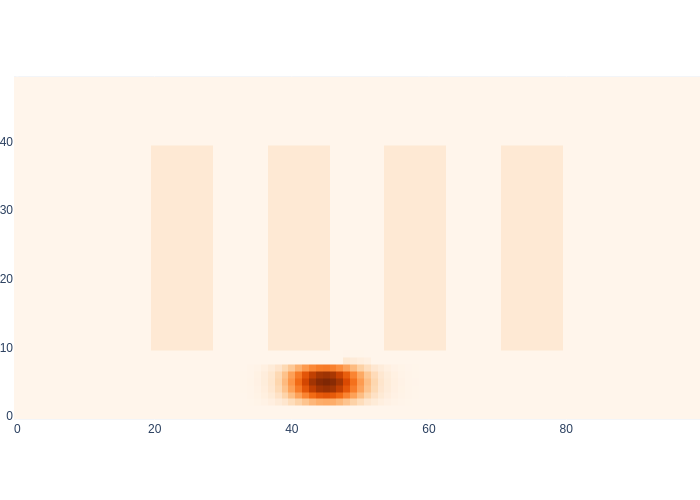
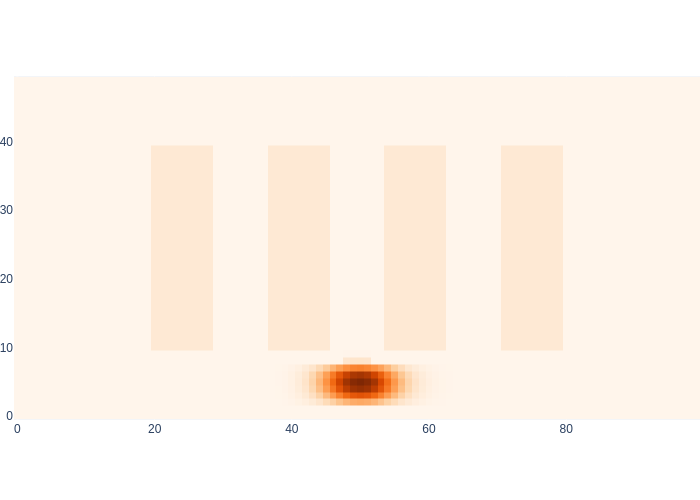
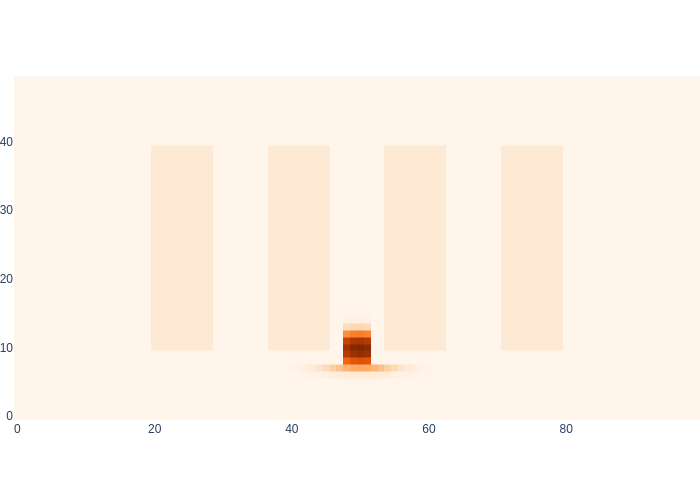
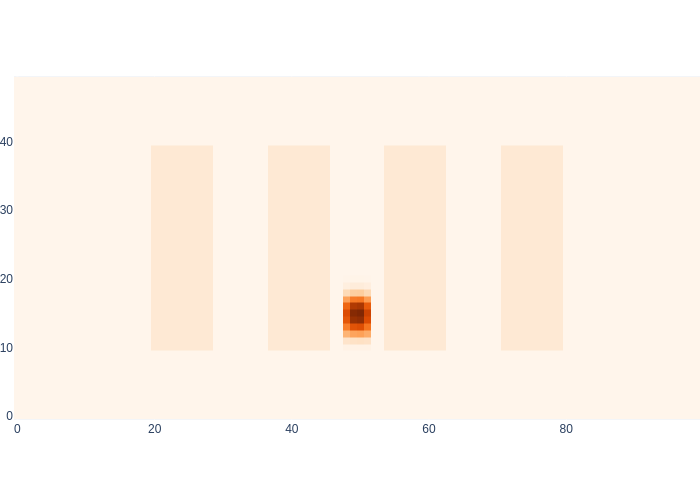
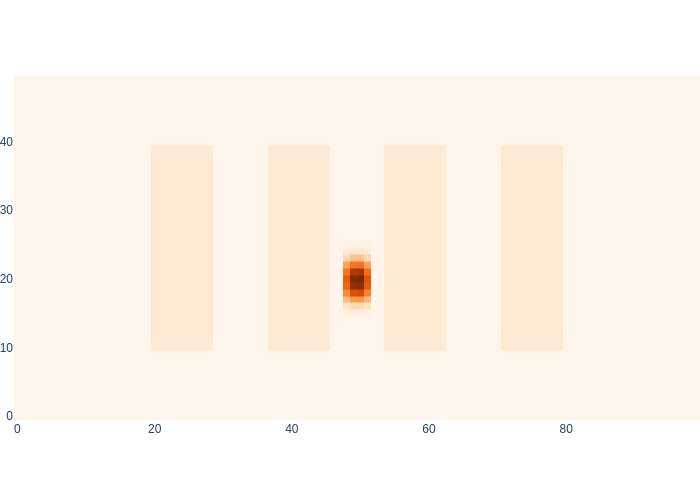
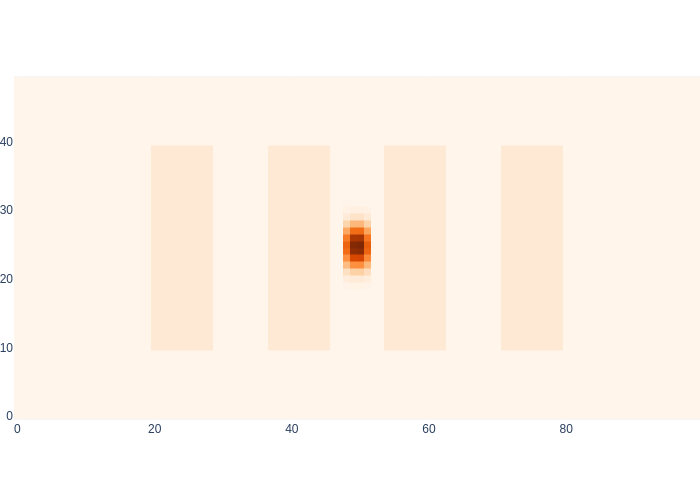
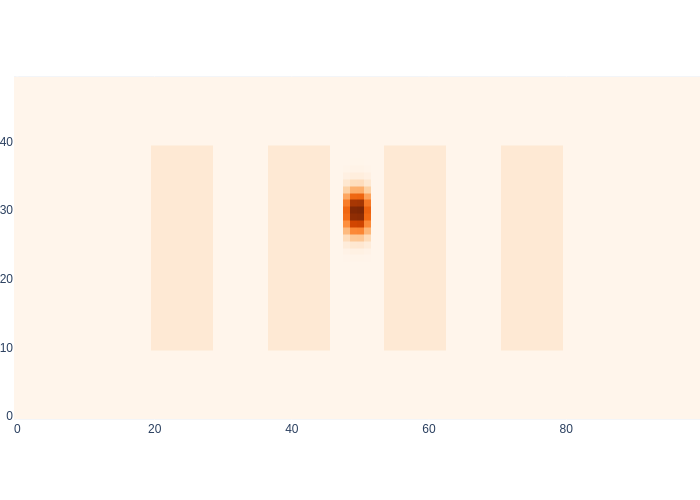

In [ ]:
"""
 If you have set show_map=True, run this cell to get the slide show 
 after running the previous cell. Otherwise, don't run this cell!
"""
create_slide_show()

In [ ]:
# Display the estimated trajectory compared with ground truth.
# Red is for estimated location, Green is for ground truth
show_trajectory(gts, np.array(best_estimates))

### TODO 1.1
Change the motion model sigma above to be `[1.0, 2.0, 3.0]`. Report the following in the corresponding report section on GradeScope:

1. The average distance (accuracy) of the algorithm for each sigma.
2. The running time of the algorithm for sigma=1.0, which can be found as `Wall time` in the outputs of the cell with `%%time`. The result will be used in part 3.



### TODO 1.2
Please provide an explanation for your observations. How does changing the motion sigma affect trajectory accuracy and sample distribution as observed in the slide shows?

# Part 2: Particle Filtering

Now, meet Jenny. Jenny uses Monte Carlo localization, or particle filtering. Particle filtering is similar to Markov localization, but different in the way it represents states: Markov localization represents state as a continuous space whereas Monte Carlo localization (partile filtering) represents state as samples collected from the space of states. 

![](https://drive.google.com/uc?export=view&id=1CeyVF3witiRfLtdvIEAZVGNUjlY90xoe)

*Art: Meet Jenny*

Particle filtering first updates the samples of the motion model with likelihood weights from previous sensor observations. It does this by resampling the prior samples with prior weights and moving all the particles (samples) with the motion control instruction (motion update stage). Then, it calculates new likelihood weights based on currect sensor observations for each particle (sensor update stage). The code below represents the process described.

Jenny uses 2 kinds of sensor readings to navigate her way around the warehouse:
1. Proximity sensor, which turns on Jenny is too close to an obstable.
2. RFID range sensor, which returns readings of `(RFID_id, distance)` when Jenny is close to the RFID sensor. There are 8 fixed RFID sensors in the map at each end of the shelves. The distance measurement is assumed to have Gaussian noise.

In [ ]:
def likelihood_off(xy):
    """
        Calculate likelihood by looking up value in proximity_map_off. 
        Returns whether the proximity sensor is off.
    """
    j, i = np.round(xy).astype(int)
    if i<0 or i>49 or j<0 or j>99: return 0.0
    return float(logistics.proximity_map_off[i,j])

In [ ]:
def likelihood_range(xy, rfid_measurement):
    """
        Calculate likelihood of xy given range measurement.
        Assumes Gaussian noise of the RFID range result.
        The function returns the likelihood that a given point matches the reading 
        of a RFID device.
    """
    _id, _range = rfid_measurement
    if _id is None:
        j, i = np.round(xy).astype(int)
        if i < 0 or i > 49 or j < 0 or j > 99:
            return 0.0
        return float(logistics.out_of_bound_map[i, j])
    else:
        sigma = 1.0  # In meters
        range_for_xy = logistics.rfid_range(xy, logistics.beacons[_id])
        # Plug in the Gaussian noise
        return 0.0 if range_for_xy is None else np.exp(-1/(2 * sigma**2) * (range_for_xy - _range)**2)

![](https://drive.google.com/uc?export=view&id=1dtJoZA1Qk24hcZaM8HLhJ8KYMi8lymgt)

*Art: Jenny uses RFID to sense range*

In [ ]:
def get_likelihood_off_weights(samples):
    """Caculate the weight for each sample based on likelihood_off output"""
    weights = np.apply_along_axis(likelihood_off, 1, samples)
    return weights

In [ ]:

def get_likelihood_range_weights(samples, position):
    """Caculate the weight for each sample based on likelihood_range output """
    range_measurement = logistics.rfid_measurement(position)
    weights = np.apply_along_axis(
      likelihood_range, 1, samples, range_measurement)
    return weights

Below is the code that define the motion update and the sensor update stages of particle filtering.

In [ ]:
def predict_samples(samples, weights, control, motion_model_sigma, size=500):
    """Create predictive density from weighted samples given control and control stddev. """
    prediction_samples = None
    weights /= np.sum(weights)
    # Resample
    component_indices = rng.choice(len(samples), size=size, p=weights)
    # Motion update
    means = samples + control
    # Inject Gaussian noise
    cov = np.eye(2) * motion_model_sigma**2
    prediction_samples = np.array([rng.multivariate_normal(means[s], cov) for s in component_indices])
    return prediction_samples

In [ ]:
def run_particle_filter(samples, indices, weights, sigma, control_values, size=500, show_map=False):
    sample_sequence = []
    for k in indices[:-1]:
        # Ground truth control instruction
        control = control_values.at(x[k+1]) - control_values.at(x[k])  
        # Predict samples based on control
        samples = predict_samples(samples, weights, control, sigma, size)
        sample_sequence.append((samples, weights))
        
        # Calculate likelihood weights for next control update
        weights = get_likelihood_off_weights(samples) \
            * get_likelihood_range_weights(samples, control_values.at(x[k+1]))
        
        if show_map:
          logistics.show_map(0.1*logistics.base_map, markers=samples,
                marker=dict(color="red", opacity=0.1, size=10*weights/np.max(weights)), file="{}.png".format(k))
          if k != indices[-2]:
            clear_output(wait=True)
    return sample_sequence

### Coding
However, similar to the problem we ran into with Manuel, all we have is an array of possible Jennys. We are only concerned about estimating *one* Jenny.
In the below cell you will implement a function to figure out Jenny's estimated location from the output samples. Use the weighted average of the locations based on the samples. (Hint: use `np.average`). 

In [ ]:
#Coding TODO 3
def get_particle_filtering_best_estimate(samples, weights):
    """
      sampels: List[(float, float)], list of sample coordinates
      weights: List[float], list of weight for each sample
      
      Returns:
        best_estimate: (float, float), the avereage of the sample coordinates with weights=weights
    """
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    best_estimate = np.average(samples, axis=0, weights=weights)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    return best_estimate

In the next cell, you will calculate the average distance between the estimated locations and the ground truth, **and the averaged distance will be used as the accuracy metric for the estimated locations in the assignment.** A higher accuracy means a lower average distance between the ground truth and the estimated locations.

You will use euclidean distance to calculate the distance between the estimated locations and the ground truth locations. (Tip: use `np.linalg.norm`) You will need to call the function you implemented above.

In [ ]:
#Coding TODO 4
def get_particle_filtering_error(sample_sequence, ground_truth_values):
    """ 
        Loop over the ground truth values and calculate the average distances using euclidean distance.
        Save your estimates in the best_estimates array and return with the accuracy.

        sample_sequence: List[(float, float)], list of tuples of samples and weights for each step
        ground_truth_values: List[(float, float)], list of ground truth locations for each step

        Returns:
          average_distance: float, average distance to ground truth
          best_estimates: List[(float, float)], list of location estimations along the trajectory for each 
            step with length equals to the ground_truth_values
    """
    average_distance = 0.0
    best_estimates = []
    n = len(ground_truth_values)
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    for k in range(len(ground_truth_values)):
        # samples, weights = sample_sequence[k]
        # best_estimate = get_particle_filtering_best_estimate(samples, weights)
        best_estimate = get_particle_filtering_best_estimate(sample_sequence[k][0], sample_sequence[k][1])
        best_estimates.append(best_estimate)
        average_distance += np.linalg.norm(best_estimate - ground_truth_values[k])
    average_distance /= n
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    # Return the average accuracy
    return best_estimates, average_distance

**The next cell will contain functions for initializing the samples. You will find them useful in a proceeding task.**

In [ ]:
# uniform
def get_uniform_distribution(num_samples): 
  return rng.uniform(low=gtsam.Point2(0,0), high=gtsam.Point2(100,50), size=(num_samples,2))

# node centered
def get_node_centered_distribution(num_samples):
  return rng.multivariate_normal(values.at(x[1]), np.diag([25,25]), size=num_samples)
  
# multi-modal distribution
def get_multi_modal_distribution(num_samples):
  prior_samples = []
  points = [[10, 6], [80, 20], [45, 25], [20, 40]]
  for i in range(4):
    center = rng.multivariate_normal(points[i], np.diag([25,25]), size=num_samples//4)
    prior_samples.append(center)
  return np.concatenate(prior_samples, axis=0)

**You will alter the following cell to complete todos for this section.**

In [ ]:
%%time
motion_model_sigma_pf = 1.0 # Alter in TODO 2.1
sample_size = 500 # Alter in TODO 2.3
samples = get_uniform_distribution(sample_size) # Alter in TODO 2.5

# We could first calculate weights to filter out unlikely samples before we start
weights = get_likelihood_off_weights(samples) \
            * get_likelihood_range_weights(samples, values.at(x[1]))
sample_sequence = [(samples, weights)]
ss = run_particle_filter(samples, indices, weights, motion_model_sigma_pf, values, sample_size, show_map=True)
sample_sequence.extend(ss)

gts = np.array([values.at(x[k]) for k in indices])
pf_best_estimates, average_distance = get_particle_filtering_error(sample_sequence, gts)
print("Average error: ", average_distance)

Average error:  9.861991212949276
CPU times: user 1.75 s, sys: 32.3 ms, total: 1.78 s
Wall time: 5.67 s



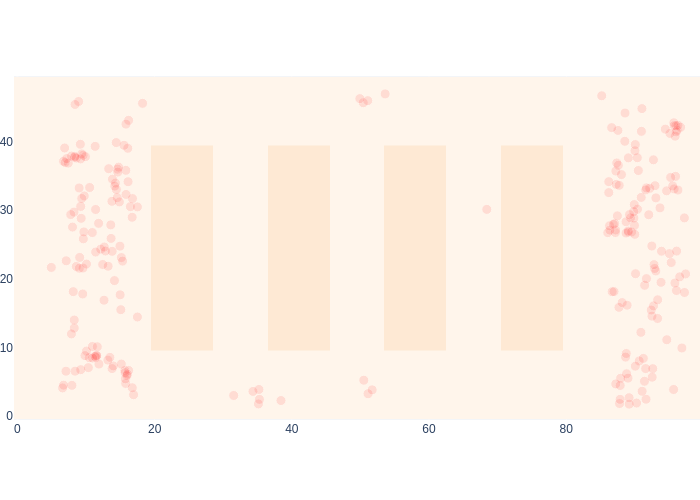
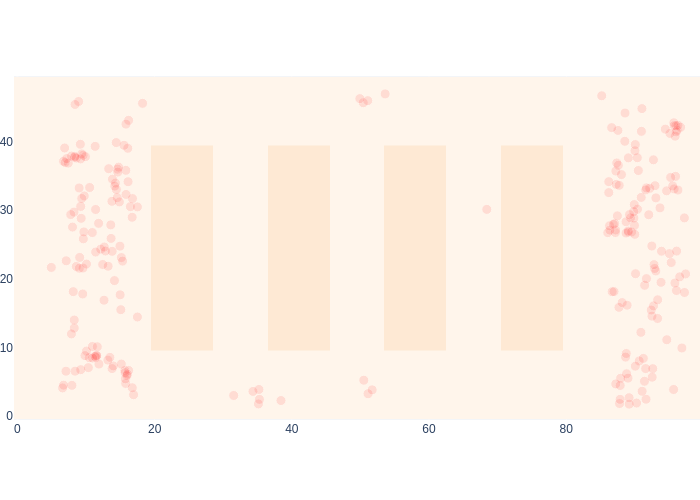
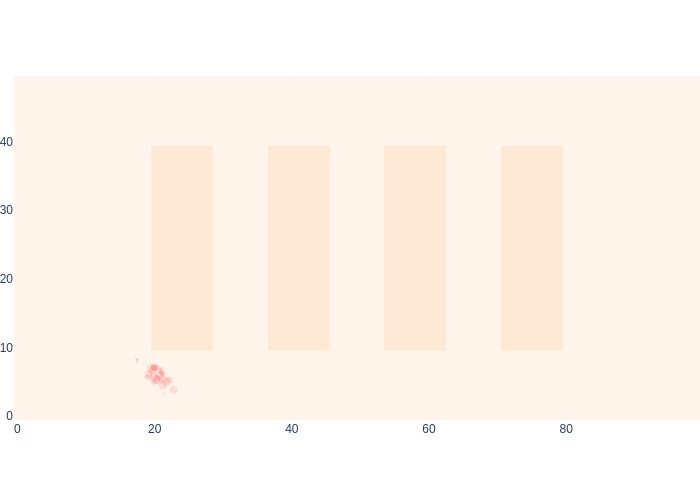
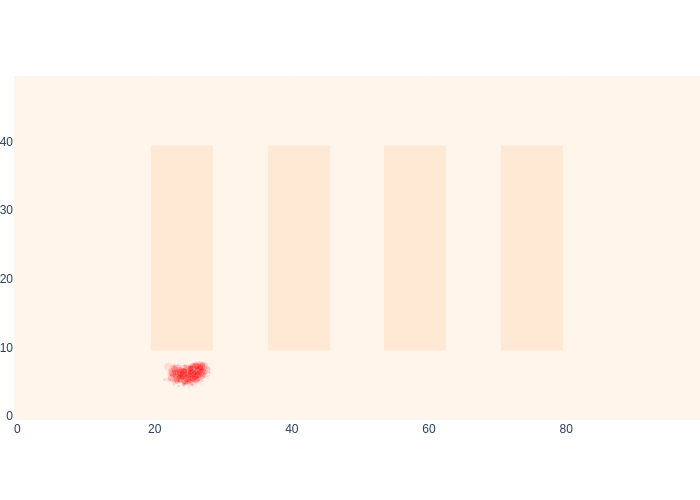
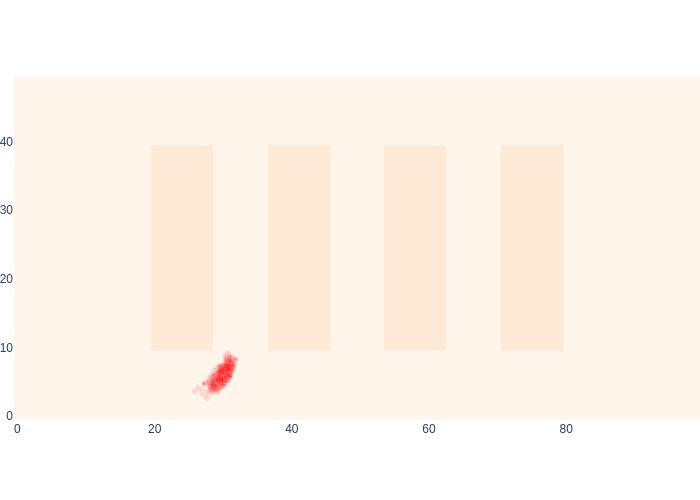
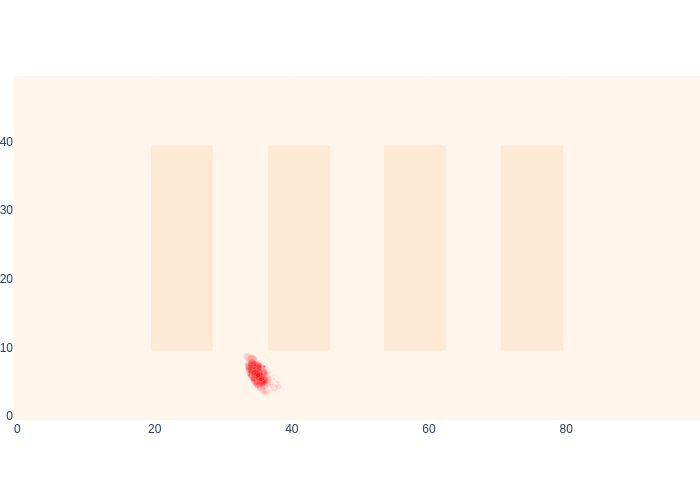
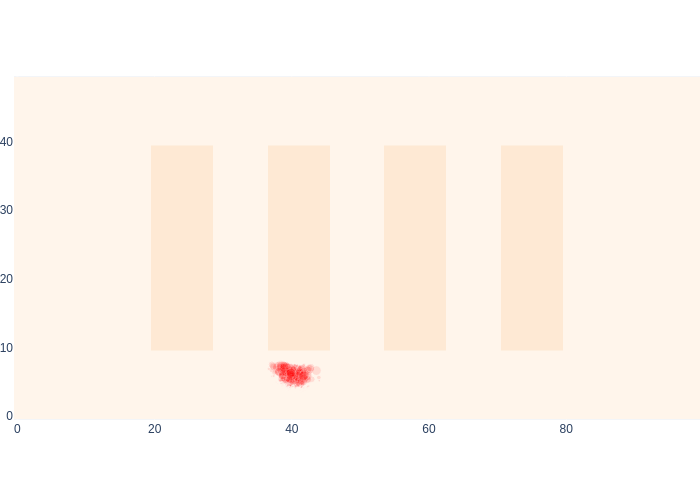
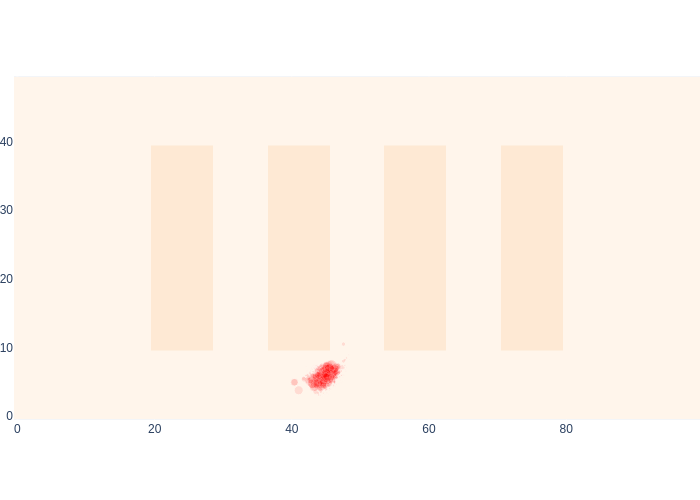
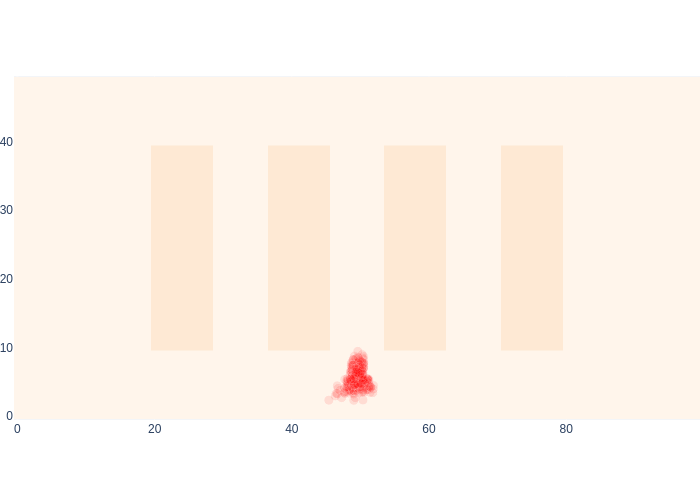
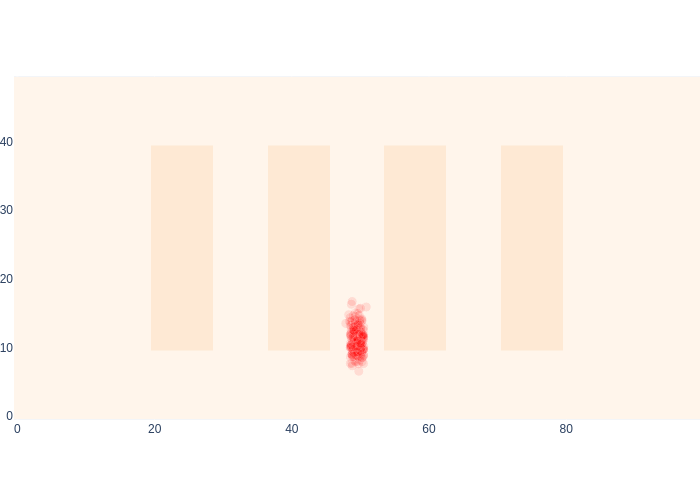
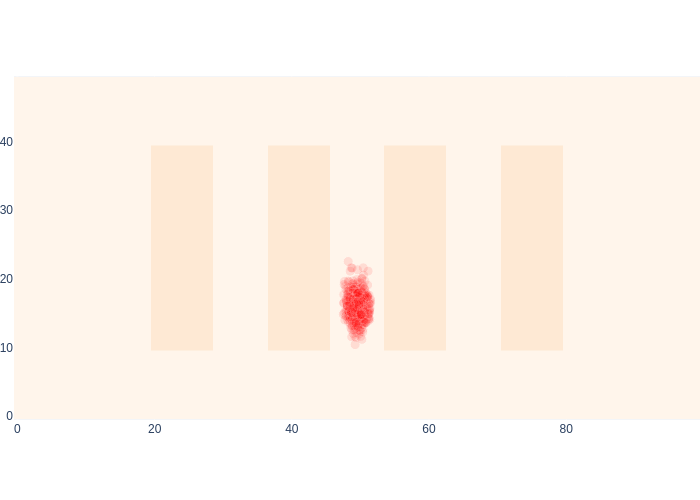
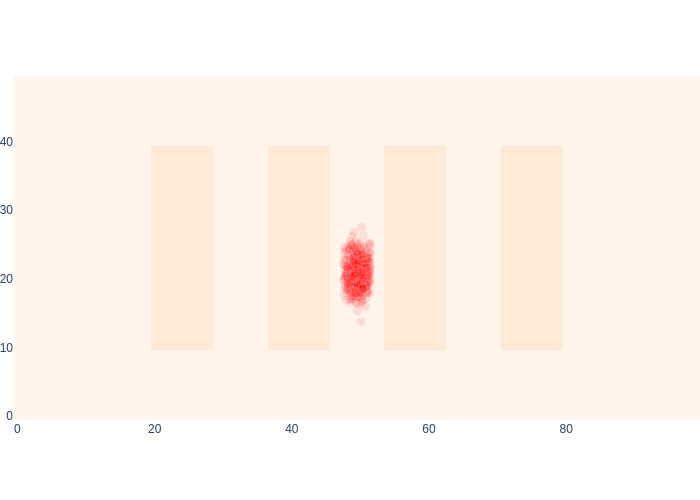
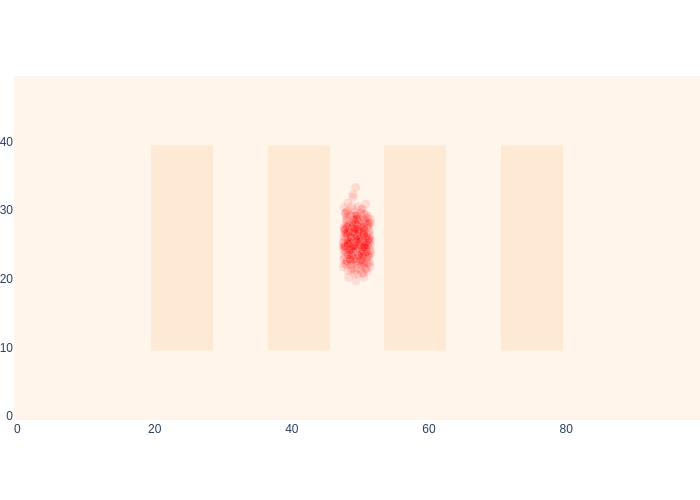
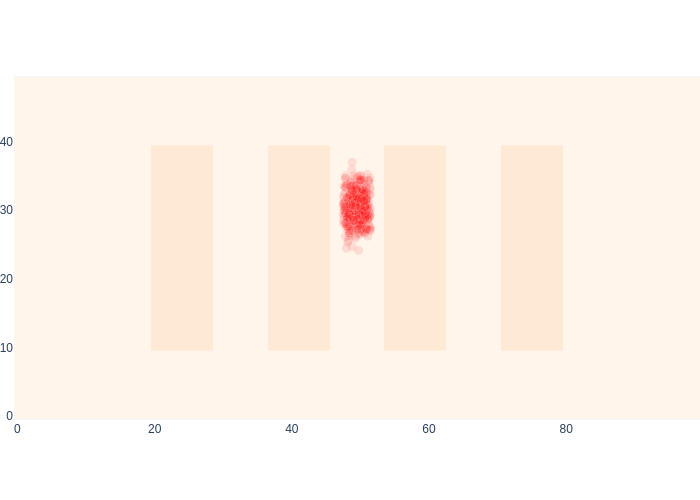

In [ ]:
"""
 If you have set show_map=True, run this cell to get the slide show 
 after running the previous cell. Otherwise, don't run this cell!
"""
create_slide_show()

In [ ]:
# Display the estimated trajectory compared with ground truth.
# Red is estimated, Green is ground truth
show_trajectory(gts, np.array(pf_best_estimates))

### TODO 2.1
**Set sample size back to `500` and the distribution back to uniform.** You will change the motion model sigma above to be `[1.0, 2.0, 3.0]`. Report the average distance of the algorithm for each sigma in the corresponding report section on Gradescope.




### TODO 2.2
Please provide an explanation for your observations. Does changing motion sigma in particle filtering have similar effects on trajectory accuracy (average distance) and sample distribution as Markov localization? Why or why not?



### TODO 2.3
**Set motion sigma back to `1.0` and distribution back to uniform.** Change the sample size to be `[500, 1000, 2000, 5000, 10000]`. Report the following in the corresponding report section on GradeScope:

1. The running time of the algorithm for each sample size - this can be found in the output of the cell with `%%time` (Important: set `show_map=False` before measuring).
2. The average distance of the algorithm for each sample size.



### TODO 2.4
Please provide an explanation for your observations. How does changing sample size affect running time and accuracy (average distances)?

![](https://drive.google.com/uc?export=view&id=1tOA9_3guARWJ-KITEKZiEV8dgOWXNt2m)

*Art: Jenny wonders - what is the best sample size?*


### TODO 2.5
**Set motion sigma back to `1.0` and sample size back to `500`.** Change the sample initialization method above to uniform, multimodal, and node-centered. Report the following in the corresponding report section on GradeScope:

1. Describe the initial distribution of the samples by referring to the code above and the generated slide show for each distribution.
2. Report the average distance (accuracy) of the algorithm given each distribution.



### TODO 2.6
Please provide an explanation for your observations. How does changing initialization lead to your observations? How will unbalanced initialization (such as multimodal distribution) affect the localization process and sample distribution?

# Part 3: Compare the two algorithms

![](https://drive.google.com/uc?export=view&id=1iOQXekxIXghwtom7WvtM1jGk0GR-vIA-)

*Art: Calvin "Kalman" Hobbs makes a bet... \$v\$*

Calvin "Kalman" Hobbs has a bet with Tom "Trial-and-Error" Robinson that Jenny can move boxes faster than Manuel. The bet is worth 5 dollars. You can use the parameters from Part 1 and 2 to help Calvin and Tom decide who gets the 5 dollars with the magic of graphs! You will plot two graphs and upload screenshots onto the Project 3 Gradescope report. No coding or parameter changing is needed for this part.

**Your results in TODO 1.1 (the running time and average distance of Markov Localization with motion sigma=1.0) and TODO 2.3 (running time and average distances of Particle Filtering with different sample sizes) will be used in this part for plotting the graphs.**

### TODO 3.1
Plot a graph with sample size on the x-axis and running time on the y-axis. We would like to compare the running time of particle filtering to that of Markov localization. Since the number of states in Markov localization in this assignment is always 5000 (equivalent to 5000 static samples), you should plot a horizontal line showing the running time of markov localization with sigma of `1.0`. Then, plot the running time of particle filtering at each sample size. Connect each point with a line if possible. You can use any plotting tool.

After plotting, answer the following questions: 

Describe the trend between running time and sample size for particle filtering. Approximately at which sample size will the running time of particle filtering reach that of markov localization?

![](https://drive.google.com/uc?export=view&id=1hcZpf2rqbF6rmDb6CbOfCsgNu6QBg0dW)

*Art: Robot too tired to run experiments*

Particle Filtering is generally faster than Markov Localization. But what about accuracy? In the next TODO, you will compare the accuracy of the two algorithms.

### TODO 3.2

Plot a graph with sample size on the x-axis and accuracy (average distance) on the y-axis. Again, please plot a horizontal line showing the accuracy (average distance) of Markov localization with sigma of `1.0`. Then, plot the scatter points of the accuracy (average distance) of particle filtering at each different sample size. Connect each  point with a line if possible. You could use any plotting tool.

After plotting, answer the following questions: 

Describe the trend between accuracy (average distance) and sample size for particle filtering. How does the accuracy (average distances) of the two algorithms compare? At what sample size is the the accuracy (average distance) of particle filtering similar to that of markov localization?


### TODO 3.3
Explain under what configuration (sample size etc.) you would prefer particle filtering over Markov localization and vice versa?

# Part 4: Path following using Particle Filtering

## 4.1 Find the location

Assume that Jenny is randomly placed into a map and has no idea where she is. She has some knowledge about the map and can obtain sensor data and motion data. Per usual, she will use Monte Carlo localization to estimate her location with proper control. The initial estimated location will be the mean of the randomly initialized samples. As in the next TODO, you will find out that motion in the map along with Monte Carlo localization will help Jenny's estimated location converge to a point close to the ground truth location. 

![](https://drive.google.com/uc?export=view&id=1pBWAvoRAlXMRXc9MY2L5enq9PBPJkVFp)

*Art: Jenny figures out her location*

In [ ]:
def show_map_with_robot(image=None, markers=None, robot=None, display=False, file: str = None, marker={}):
    """ Utility function to show image on warehouse map, possibly with markers and robots """
    fig = px.imshow(image, color_continuous_scale='Oranges',
                    origin="lower", aspect='equal', range_color=[0, 1])
    fig.add_scatter(x=[int(robot[0])], y=[int(robot[1])], mode="markers", marker=dict(color="green", opacity=1, size=10))
    if markers is not None:
        fig.add_scatter(x=markers[:, 0], y=markers[:, 1],
                        mode="markers", marker=marker)
        
    fig.update_layout(coloraxis_showscale=False,
                      margin=dict(l=0, r=0, t=0, b=0))
    fig.update_xaxes(range=[-0.5, 99.5], autorange=False)
    fig.update_yaxes(range=[-0.5, 49.5], autorange=False,scaleratio = 1)
    if display:
        fig.show()
    if file is not None:
        fig.write_image(file)

### Coding

In [ ]:
class WarehouseNavigator():
  def __init__(self):
    self.controls = {'UP': (0, 2), 'DOWN': (0, -2), 'LEFT': (-2, 0), 'RIGHT': (2, 0)}
    self.ground_truth = np.array([0, 0]).astype(np.float64)
    self.motion_sigma = 1
    self.sample_size = 2000

  def reset_ground_truth(self, point):
    self.ground_truth = np.array(point).astype(np.float64)

  def update_ground_truth(self, control):
    self.ground_truth += np.array(control).astype(np.float64)

  def get_rfid_measurement(self):
    return logistics.rfid_measurement(self.ground_truth)

  def save_map(self, index, samples, weights):
    show_map_with_robot(0.1*logistics.base_map, markers=samples,
              marker=dict(color="red", opacity=0.1, size=10*weights/np.max(weights)), 
              robot=self.ground_truth, 
              display=False,
              file="{}.png".format(index))
    
  def stopping_criteria(self, est_loc, target):
    """ 
        The robot should stop within 1.0 in distance to the target or if it's out of bounds. 
        Use likelihood_off(self.ground_truch) to detect out of bounds.
        Think about what should likelihood_off return when the robot is about to go out of bounds?
        Return a boolean. 
    """
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    #Coding TODO 5
    return (np.linalg.norm(target - est_loc) < 1.0) or not(likelihood_off(self.ground_truth))
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

  def update_estimate(self, samples, weights):
    """ Return the estimated location using the function you filled before. """
    return get_particle_filtering_best_estimate(samples, weights) 
    
  def follow_straight_path(self, start, target, direction='LEFT', prior_samples=None, save_map=False):
    """
        Follows a straight path with given start and target in a specified direction. 
        Provide a prior_samples if you would like a pre-initialized sample distribution.

        Returns:
          est_locs: list of estimated_locations for each step
          gts: list of ground truths for each step
          samples: list of samples in the last step of the while loop
    """
    self.reset_ground_truth(start)
    init_rfid_measurement = self.get_rfid_measurement()
    samples = get_uniform_distribution(self.sample_size) if prior_samples is None else prior_samples
    if save_map:
      self.save_map(0, samples, np.ones(self.sample_size)/self.sample_size)

    index = 0
    weights = get_likelihood_off_weights(samples) \
            * get_likelihood_range_weights(samples, start)

    est_loc = self.update_estimate(samples, weights)
    est_locs = [est_loc]
    gts = [self.ground_truth.copy()]
    
    while not self.stopping_criteria(est_loc, target):
        ###############################################################################
        #                             START OF YOUR CODE                              #
        ###############################################################################
        #Coding TODO 6
        # One-liner: What control would you use here?
        control = self.controls[direction]
        ###############################################################################
        #                              END OF YOUR CODE                               #
        ###############################################################################

        self.update_ground_truth(control)
        samples = predict_samples(samples, weights, control, self.motion_sigma, size=self.sample_size)
        rfid_measurement = self.get_rfid_measurement()
        weights = get_likelihood_off_weights(samples) * get_likelihood_range_weights(samples, self.ground_truth)
        
        est_loc = self.update_estimate(samples, weights)
        est_locs.append(est_loc)
        gts.append(self.ground_truth.copy())
        index += 1
        if save_map:
          self.save_map(index, samples, weights)
    return est_locs, gts, samples

In [ ]:
# Way points
starting_point = [40, 7]
destination = [60, 7]
navigator = WarehouseNavigator()
est_locs, line_gts, _ = navigator.follow_straight_path(starting_point, destination, 'RIGHT', save_map=True)
average_distance = np.sum([np.linalg.norm(est_loc - gt) for est_loc, gt in zip(est_locs, line_gts)])/len(line_gts)
print("Average distance: ", average_distance)

Average distance:  0.9402993486224592


In [ ]:
create_slide_show()

ValueError: ignored

In [ ]:
# Display the estimated trajectory compared with ground truth.
# Red is estimated, Green is ground truth
show_trajectory(np.array(line_gts), np.array(est_locs))

If your implementation is correct, you should see the red sample points converge to the point of the robot (black dot in the map) after a few steps in the slide show. Sometimes, if the initialization is good enough, you'll find the estimated location is close to the ground truth after the first step. The robot dot will be covored by the red samples if their locations are similar.

### TODO 4.1

Insert a screenshot of the trajectory in the Gradescope report and report the average distance (accuracy).

## 4.2 A more complicated path

Based on the previous example, you will create an advanced warehouse navigator to follow a path with multiple waypoints! Notice that the path could be decomposed into multiple `follow_straight_path()`executions to reach the final destination, since between each waypoints lies a straight path. You will implement the function `follow_path_with_waypoints` and observe the final distance to the destination. If your implementation for `follow_straight_path()` is correct, the robot should stop close to the waypoints, and the distance to every waypoint when stopping is within `1.0` (based on stopping criteria in the `follow_straight_path()` function).

In [ ]:
# Waypoints
waypoints = [[30, 44], [50, 44], [50, 6], [66, 6], [66, 44], [80, 44]]

### Coding

In [ ]:
class AdvancedWarehouseNavigator(WarehouseNavigator):
  def __init__(self):
    super().__init__()

  def get_direction(self, start, end):
    """ Return the estimated direction of the straight path as a string. """
    if start[0] == end[0]:
      if start[1] > end[1]:
        return 'DOWN'
      elif start[1] < end[1]:
        return 'UP'
    else:
      if start[0] > end[0]:
        return 'LEFT'
      elif start[0] < end[0]:
        return 'RIGHT'
    

  def follow_path_with_waypoints(self, waypoints):
    """
      Use self.follow_straight_path() to complete this function. You could assume 
      that the robot's ground truth location is at the first waypoint. The robot 
      will always move in the 4 directions defined in the class, and the waypoints 
      will always be in the 4 directions related to each other. You could use any 
      function defined in this class and its super-class.
      
      ** Set save_map=False when running follow_straight_path()! **
      ** When calling self.get_direction, use the given way points **

      The navigation could run for a while!

      Return: 
        est_pts: a list of your estimated position along the trajectory
        gts: a list of ground truths along the trajectory
    """
    est_pts = []                 # Estimated locations along the full trajectory
    traj_gts = []                # Ground truth lcoations along the full trajectory
    prev_waypoint = waypoints[0] # Useful for calculating direction
    prev_sample = None           # Set prior_samples=prev_sample when calling follow_straight_path
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    #Coding TODO 7
    # Remember to update the variables after each loop of follow_straight_path()
    for waypoint in waypoints[1:]:
      ests, gts, sample = self.follow_straight_path(prev_waypoint, waypoint, self.get_direction(prev_waypoint, waypoint), prior_samples=prev_sample)
      est_pts.extend(ests)
      traj_gts.extend(gts)
      prev_waypoint = waypoint
      prev_sample = sample
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    return est_pts, traj_gts

In [ ]:
adv_navigator = AdvancedWarehouseNavigator()
est_pts, traj_gts = adv_navigator.follow_path_with_waypoints(waypoints)
average_distance = np.sum([np.linalg.norm(est_loc - gt) for est_loc, gt in zip(est_locs, traj_gts)])/len(traj_gts)
print("Avereage distance: ", average_distance)

Avereage distance:  6.053480003982311


In [ ]:
# Display the estimated trajectory compared with ground truth.
# Red is estimated, Green is ground truth
show_trajectory(np.array(traj_gts), np.array(est_pts))

### TODO 4.2

Insert a screenshot of the trajectory into the report on Gradescope and report the accuracy (average distance).

# Submission


Upload your notebook to Google Colab and run all the cells after filling out the coding portion. Now that you have completed everything in this notebook, download your notebook as `submission.py` and comment out all the lines with `create_slide_show()` and `show_trajectory()`. If you don't comment out the lines, Gradescope autograder would throw errors. 

***All answers to non-coding questions should be submitted to the "Project 3 Report" online assignment on Gradescope. The notebook will not be graded.***